Komiwojażer

chromosom - wektor zawierajacy n liczb naturalnych - numery miast(strona 40 na prezce) - funkcje do permutacji liczb losowych
f jakosci - suma odleglosci miast po koleji 

pop poczatkowa - tablica 2 wymiarowa (str 44)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt
from copy import deepcopy
from matplotlib.animation import FuncAnimation
import imageio

In [3]:
# generowanie miast i populacji
def generate_cities(num_cities=10, x_range=(0, 301), y_range=(0, 301)):
    """Generacja miast - generuje określoną ilos miast z losowymi wspolrzednymi z zakresu x_range i y_range
    num_cities - liczba miast do odwiedzenia
    x_range - zakres wspolrzednych x
    y_range - zakres wspolrzednych y
    """

    cities = []
    for i in range(num_cities):
        x = random.randint(*x_range)
        y = random.randint(*y_range)
        cities.append((x, y))
    return cities

def generate_population(pop_size=50, num_cities=10):
    """Generacja populacji - tablica o dlugosci rownej ilosci miast z losowymi permutacjami kolejności ich odwiedzin
    pop_size - liczba osobnikow w populacji
    num_cities - liczba miast do odwiedzenia
    """
    
    population = []
    for _ in range(pop_size):
        el = list(range(num_cities))
        random.shuffle(el)
        population.append(el)
    return population

pop=generate_population()
cities=generate_cities()
print(cities)
print(pop)


[(64, 41), (140, 213), (184, 114), (251, 155), (288, 254), (63, 157), (228, 86), (109, 215), (215, 32), (156, 259)]
[[2, 9, 0, 6, 1, 3, 4, 7, 5, 8], [0, 6, 8, 5, 4, 1, 3, 2, 7, 9], [1, 7, 2, 5, 0, 9, 3, 4, 6, 8], [3, 1, 4, 7, 6, 9, 5, 8, 2, 0], [6, 7, 3, 2, 4, 8, 5, 9, 1, 0], [7, 2, 5, 3, 0, 1, 4, 8, 6, 9], [9, 2, 4, 0, 6, 7, 5, 8, 1, 3], [7, 3, 6, 4, 1, 2, 0, 9, 5, 8], [9, 1, 0, 6, 5, 7, 3, 4, 2, 8], [1, 6, 2, 3, 8, 7, 9, 5, 4, 0], [2, 0, 1, 8, 4, 6, 7, 5, 3, 9], [0, 3, 6, 2, 1, 9, 7, 8, 5, 4], [6, 0, 1, 7, 5, 8, 3, 4, 9, 2], [2, 6, 4, 5, 7, 1, 0, 3, 9, 8], [7, 6, 2, 0, 5, 8, 9, 4, 3, 1], [3, 1, 9, 7, 8, 4, 2, 5, 0, 6], [6, 0, 7, 1, 2, 9, 8, 3, 4, 5], [2, 1, 5, 3, 0, 8, 9, 6, 7, 4], [9, 0, 7, 3, 8, 6, 1, 5, 4, 2], [7, 6, 4, 9, 5, 0, 1, 8, 2, 3], [6, 8, 0, 9, 5, 2, 4, 7, 3, 1], [0, 8, 6, 1, 2, 9, 4, 5, 7, 3], [3, 0, 2, 6, 8, 7, 5, 9, 1, 4], [0, 6, 7, 5, 9, 2, 8, 4, 1, 3], [5, 0, 3, 6, 9, 4, 2, 8, 7, 1], [8, 6, 5, 4, 7, 2, 9, 0, 3, 1], [5, 2, 4, 1, 0, 7, 9, 3, 8, 6], [8, 4, 1, 5, 3, 7, 

In [ ]:
#funkcje do obliczania dystansu (fitness)

def distance(city1, city2):
    """Obliczanie odleglosci euklidesowej miedzy dwoma miastami"""

    return sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def calculate_distance_matrix(cities):   
    """Funkcja obliczajaca macierz odleglosci miedzy miastami (miasto x miasto), dzieki czemu nie musimy w kazdej iteracji obliczac na nowo dystansu
    cities = lista wygenerowanych miast (x, y)
    """
    
    num_cities = len(cities) 
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = distance(cities[i], cities[j])                 
    return distance_matrix

DistanceMatrix=calculate_distance_matrix(cities)

def fitness(route, distance_matrix):
    """Funkcja oceny osobnika: im mniejsza wartość, tym lepiej(minimalizacja dystansu)
    route = lista kolejnosci miast (osobnik)
    distance_matrix = macierz odleglosci (miasto x miasto) 
    """
    
    total_distance = 0
    for i in range(len(route)-1):
        total_distance += distance_matrix[route[i]][route[i+1]]
    total_distance += distance_matrix[route[-1]][route[0]]  
    return total_distance  #minimalizujemy

#testy
# for _ in range(10000):
#     pop = generate_population()
#     cities = generate_cities()
#     print(pop[0])  # test
#     print(fitness(pop[0], calculate_distance_matrix(cities)) ) 



[2, 9, 3, 5, 6, 7, 0, 4, 1, 8]
1490.0287451391885
[4, 5, 7, 3, 8, 6, 2, 9, 1, 0]
1112.1312035086783
[3, 0, 6, 9, 1, 7, 5, 4, 8, 2]
1538.1193474702184
[5, 1, 0, 9, 6, 7, 3, 4, 8, 2]
1507.4050055405676
[5, 6, 9, 7, 2, 8, 1, 3, 4, 0]
1215.3830154267168
[5, 7, 4, 8, 3, 1, 0, 6, 2, 9]
1396.6328329844437
[4, 7, 6, 5, 8, 1, 0, 3, 2, 9]
2071.836772527915
[5, 6, 3, 4, 7, 0, 8, 2, 1, 9]
962.9626291560238
[1, 2, 5, 3, 0, 7, 4, 9, 8, 6]
1480.9386442936504
[5, 4, 1, 3, 8, 9, 0, 7, 2, 6]
1223.6970225210523
[1, 3, 6, 8, 0, 5, 2, 9, 7, 4]
1189.5414200487191
[6, 8, 5, 0, 1, 9, 2, 7, 4, 3]
1380.9020089959192
[7, 9, 0, 5, 2, 4, 1, 3, 8, 6]
1737.061443749856
[3, 1, 7, 2, 9, 4, 8, 5, 6, 0]
2002.9954192319901
[6, 7, 9, 5, 4, 1, 8, 0, 3, 2]
1761.357734080373
[8, 3, 9, 7, 5, 6, 0, 1, 4, 2]
1680.98639338669
[3, 5, 0, 8, 6, 4, 7, 9, 1, 2]
1499.486802787662
[2, 3, 6, 1, 8, 4, 0, 7, 9, 5]
1658.777812682544
[5, 8, 6, 2, 3, 4, 0, 1, 9, 7]
1600.5836339547245
[3, 7, 0, 9, 2, 5, 6, 4, 1, 8]
1309.666047139266
[3, 4, 1,

In [8]:
#selekcja


#ranking selection
def sort_population(population, distance_matrix):
    """Sortowanie populacji wedlug funkcji przystosowania - zwraca posortowaną populacje, od najlepszego do najgorszego osobnika (najmiejszy dystans do najwiekszego)
    population = lista osobników (tras - kolejnosci indeksow miast)
    distance_matrix = macierz odleglosci (miasto x miasto)
    """
    
    return sorted(population, key=lambda x: fitness(x, distance_matrix)) 

def rank_selection(population, distance_matrix, selection_ratio=0.5):
    """Selekcja rankingowa - wybór tylko pewnej najlepszej części populacji do następnego rozmnażania
    population = lista osobników (tras - kolejnosci indeksow miast)
    distance_matrix = macierz odleglosci (miasto x miasto)
    Selection ratio - proporcja populacji, która ma być wybrana do następnej generacji."""

    selection_size= int(len(population) * selection_ratio)
    sorted_population = sort_population(population, distance_matrix)
    return sorted_population[:selection_size]

print(sort_population(pop, DistanceMatrix))
print(rank_selection(pop, DistanceMatrix))


[[2, 7, 0, 5, 8, 9, 1, 4, 3, 6], [5, 1, 3, 9, 8, 7, 2, 4, 0, 6], [5, 1, 2, 8, 9, 4, 7, 0, 3, 6], [4, 0, 1, 7, 3, 6, 5, 9, 8, 2], [9, 8, 2, 0, 6, 1, 4, 7, 5, 3], [1, 3, 4, 7, 6, 0, 5, 2, 8, 9], [1, 6, 0, 4, 5, 9, 8, 7, 3, 2], [3, 2, 5, 8, 9, 1, 4, 0, 6, 7], [1, 6, 3, 7, 9, 8, 0, 4, 2, 5], [0, 9, 5, 8, 6, 2, 1, 3, 4, 7], [1, 6, 3, 4, 2, 0, 7, 5, 9, 8], [1, 8, 5, 0, 3, 6, 9, 2, 4, 7], [5, 2, 3, 6, 0, 1, 4, 9, 8, 7], [8, 9, 1, 7, 3, 6, 4, 0, 2, 5], [2, 1, 3, 0, 8, 6, 7, 5, 9, 4], [2, 1, 5, 9, 0, 3, 8, 4, 7, 6], [8, 2, 6, 5, 9, 0, 4, 7, 1, 3], [3, 6, 9, 1, 2, 7, 8, 5, 0, 4], [9, 1, 0, 7, 6, 2, 3, 4, 5, 8], [0, 6, 7, 3, 8, 2, 4, 1, 9, 5], [5, 0, 1, 2, 8, 7, 4, 6, 3, 9], [8, 2, 4, 1, 9, 5, 6, 7, 3, 0], [3, 1, 7, 2, 9, 4, 0, 6, 8, 5], [3, 5, 1, 9, 0, 8, 2, 7, 4, 6], [6, 7, 5, 3, 9, 1, 2, 4, 0, 8], [4, 3, 2, 6, 0, 9, 5, 1, 8, 7], [6, 7, 1, 0, 3, 8, 5, 9, 2, 4], [0, 3, 5, 9, 7, 2, 6, 8, 4, 1], [1, 6, 3, 7, 2, 9, 4, 5, 0, 8], [9, 2, 7, 6, 8, 5, 4, 3, 1, 0], [8, 5, 1, 9, 0, 2, 6, 3, 4, 7], [1, 7, 

In [ ]:
#krzyżowanie i mutacja

def legalize_child(child, size):
    seen = set()
    duplicates = set()
    for num in child:
        if num in seen:
            duplicates.add(num)
        seen.add(num)
    
    missing = set(range(size)) - seen

    missing = list(missing)
    for i in range(len(child)):
        if child[i] in duplicates:
            if missing:
                duplicates.remove(child[i])
                child[i] = missing.pop()
            else:
                break  

def crossover(parent1, parent2):
    size = len(parent1)
    loc_start = random.randint(0, size - 1)
    loc_end = random.randint(loc_start, size - 1)

    par1_crossover = parent1[loc_start:loc_end]
    par2_crossover = parent2[loc_start:loc_end]

    child1 = parent1.copy()
    child2 = parent2.copy()
    child1[loc_start:loc_end] = par2_crossover
    child2[loc_start:loc_end] = par1_crossover

    legalize_child(child1, size)
    legalize_child(child2, size)

    return child1, child2


def mutation(individual, mutation_rate=0.05):
    """Mutacja - zamiana miejscami dwóch losowych miast w trasie
    individual - osobnik (trasa)
    mutation_rate - prawdopodobieństwo mutacji (0-1)
    """
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual


[3, 7, 9, 2, 1, 5, 8, 4, 0, 6]
[1, 8, 5, 0, 3, 6, 9, 2, 4, 7]
[1, 7, 9, 2, 3, 5, 8, 4, 0, 6] [3, 8, 5, 0, 1, 6, 9, 2, 4, 7]
[1, 7, 9, 4, 3, 5, 8, 2, 0, 6] [3, 8, 5, 0, 1, 6, 9, 2, 4, 7]
[7, 9, 4, 1, 3, 5, 8, 2, 0, 6] [5, 3, 8, 0, 1, 6, 9, 2, 4, 7]
[7, 8, 0, 1, 3, 5, 9, 2, 4, 6] [5, 3, 4, 9, 1, 6, 8, 2, 0, 7]
[7, 4, 9, 1, 3, 5, 8, 2, 0, 6] [5, 3, 8, 0, 1, 6, 9, 2, 4, 7]
[7, 5, 3, 0, 1, 8, 9, 2, 4, 6] [6, 4, 9, 1, 3, 5, 8, 2, 0, 7]
[7, 5, 3, 0, 1, 8, 9, 2, 4, 6] [6, 4, 9, 1, 3, 5, 8, 2, 0, 7]
[7, 5, 3, 0, 1, 8, 9, 2, 4, 6] [6, 4, 9, 1, 3, 5, 8, 2, 0, 7]
[7, 5, 3, 0, 1, 8, 9, 2, 4, 6] [6, 4, 9, 1, 3, 5, 8, 2, 0, 7]
[7, 8, 0, 1, 3, 5, 9, 2, 4, 6] [6, 5, 3, 4, 1, 9, 8, 2, 0, 7]
[7, 8, 0, 1, 3, 5, 9, 2, 4, 6] [6, 5, 3, 4, 1, 9, 8, 2, 0, 7]
[7, 8, 0, 5, 1, 3, 9, 2, 4, 6] [6, 9, 1, 4, 3, 5, 8, 2, 0, 7]
[7, 8, 0, 5, 1, 3, 9, 2, 4, 6] [6, 9, 1, 4, 3, 5, 8, 2, 0, 7]
[7, 8, 0, 5, 1, 3, 9, 2, 4, 6] [6, 9, 1, 4, 3, 5, 8, 2, 0, 7]
[7, 8, 0, 5, 1, 3, 9, 2, 4, 6] [6, 9, 1, 4, 3, 5, 8, 2, 0, 7]
[7, 4, 3

In [242]:
#algorytm genetyczny
def genetic_algorithm(cities, pop_size=50, generations=100, mutation_rate=0.1):
    """Algorytm genetyczny - główna funkcja, która wykonuje algorytm genetyczny
    cities - lista miast (x, y)
    pop_size - liczba osobników w populacji
    generations - liczba pokoleń
    mutation_rate - prawdopodobieństwo mutacji (0-1)
    """
    
    num_cities = len(cities)
    population = generate_population(pop_size, num_cities)
    DistanceMatrix = calculate_distance_matrix(cities)
    best_fitness_history = []
    avg_fitness_history = []
    best_route_history = []
    
    for gen in range(generations):
        # Ocena populacji
        fitness_scores = [fitness(ind, DistanceMatrix) for ind in population]
        best_fitness = min(fitness_scores)
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)

        best_route_index = np.argmin(fitness_scores)
        best_route = population[best_route_index]   
        best_route_history.append(best_route)
        
        # Selekcja
        selected = rank_selection(population, DistanceMatrix)
        
        # Krzyżowanie
        
        random.shuffle(selected) #przemieszanie rodziców
        children = []
        
        for i in range(0, len(selected)-1, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            children.append(child1)
            children.append(child2)
        
        
        # Mutacja
        mutated_children = [mutation(child, mutation_rate) for child in children]
        
        # Tworzenie nowej populacji
        population = selected + mutated_children
        
        # Uzupełnij populację losowymi osobnikami jeśli potrzeba
        while len(population) < pop_size:
            individual = list(range(num_cities))
            random.shuffle(individual)
            population.append(individual)
    
    # Znajdź najlepsze rozwiązanie
    best_index = np.argmin([fitness(ind, DistanceMatrix) for ind in population])
    best_individual = population[best_index]
    best_distance = fitness(best_individual, DistanceMatrix)
    
    return best_individual, best_distance, best_fitness_history, avg_fitness_history, best_route_history




In [239]:
# Wizualizacja wyników
def plot_results(cities, best_route, fitness_history, avg_fitness_history):
    plt.figure(figsize=(15, 5))
    DistanceMatrix = calculate_distance_matrix(cities)
    # Wykres trasy
    plt.subplot(1, 2, 1)
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='red')
    
    # Rysowanie trasy
    for i in range(len(best_route)):
        city1 = cities[best_route[i]]
        city2 = cities[best_route[(i+1)%len(best_route)]]
        plt.plot([city1[0], city2[0]], [city1[1], city2[1]], 'b-')
    
    plt.title(f'Najlepsza trasa: {fitness(best_route, DistanceMatrix):.2f}')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Wykres efektywności algorytmu
    plt.subplot(1, 2, 2)
    plt.plot(fitness_history, label='Najlepszy osobnik')
    plt.plot(avg_fitness_history, label='Średnia populacji')
    plt.title('Efektywność algorytmu')
    plt.xlabel('Pokolenie')
    plt.ylabel('Długość trasy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



Najlepsza znaleziona trasa: [28, 6, 2, 21, 11, 37, 14, 16, 47, 34, 15, 9, 7, 20, 24, 36, 8, 35, 42, 31, 40, 45, 39, 22, 3, 17, 48, 5, 0, 27, 41, 33, 32, 4, 23, 29, 43, 26, 30, 49, 25, 13, 44, 38, 19, 12, 1, 10, 18, 46]
Długość trasy: 2241.12


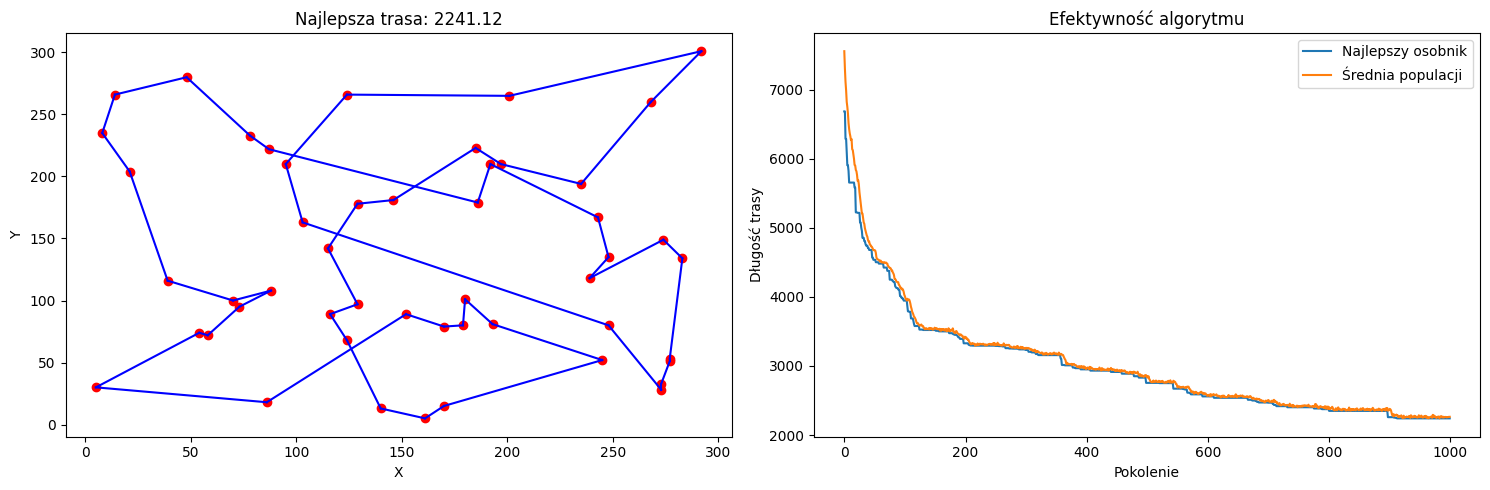

In [245]:
# Parametry algorytmu
num_cities = 50
pop_size = 100
generations = 1000
mutation_rate = 0.1
elite_size = 2


# Generowanie miast i uruchomienie algorytmu
cities = generate_cities(num_cities, x_range=(0, 301), y_range=(0, 301))



best_route, best_distance, best_fitness_history,avg_fitness_history,route_history = genetic_algorithm( cities,
pop_size, generations, mutation_rate)

# best_route, best_distance, best_history, avg_history = genetic_algorithm(
#     cities, pop_size, generations, mutation_rate
# )

# Wyświetlenie wyników
print(f"Najlepsza znaleziona trasa: {best_route}")
print(f"Długość trasy: {best_distance:.2f}")

# Wizualizacja



plot_results(cities, best_route, best_fitness_history, avg_fitness_history)
